# Chest Xrays(Pneumonia) - Training and deploying our Keras CNN on SageMaker

Based on https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia

In [2]:
#import necessary libraries

import os
import tarfile
import urllib
import shutil
import json
import random
import numpy as np
import tensorflow as tf
import sagemaker
import pandas as pd
from glob import glob
import cv2
import seaborn as sns

from PIL import Image
from matplotlib import pyplot as plt

In [2]:
#make directory for images 

!mkdir data

In [36]:
path = 'archive.zip'

In [5]:
# Extract the files from dataset to temp_train and temp_test folders (as the dataset is a zip file.)
from zipfile import ZipFile
with ZipFile(path, 'r') as zip:
  zip.extractall('./data')

In [34]:
root_dir = './data/chest_xray'

## Visualize Data

In [41]:
path = "./chest_xray/train/*/*.jpeg"                              # The path to all images in training set. (* means include all folders and files.)
files = glob(path)

trainImg = []                                              # Initialize empty list to store the image data as numbers.
trainLabel = []                                            # Initialize empty list to store the labels of images
j = 1
num = len(files)

# Obtain images and resizing, obtain labels
for img in files:
    '''
    Append the image data to trainImg list.
    Append the labels to trainLabel list.
    '''
    print(str(j) + "/" + str(num), end="\r")
    trainImg.append(cv2.resize(cv2.imread(img), (128, 128)))  # Get image (with resizing to 128x128)
    trainLabel.append(img.split('/')[-2])  # Get image label (folder name contains the class to which the image belong)
    j += 1

trainImg = np.asarray(trainImg)  # Train images set
#trainLabel = pd.DataFrame(trainLabel)  # Train labels set

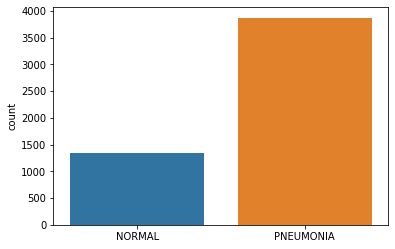

In [42]:
#Visualize the classes to check for imbalance 

sns.countplot(trainLabel)

Text(0.5, 1.0, 'PNEUMONIA')

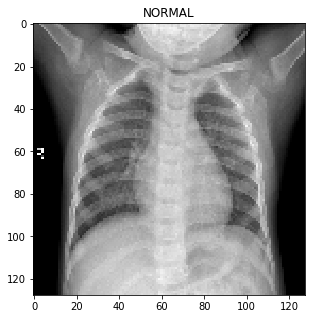

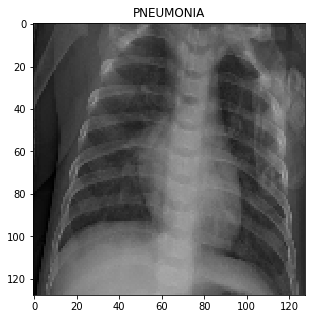

In [43]:
#Visualize Image of Normal Xray and Pneumonia Xray
plt.figure(figsize = (5,5))
plt.imshow(trainImg[0], cmap='gray')
plt.title(trainLabel[0])

plt.figure(figsize = (5,5))
plt.imshow(trainImg[-1], cmap='gray')
plt.title(trainLabel[-1])

## Write CNN training script

In [44]:
%%writefile train.py


import tensorflow as tf
import argparse
import os
import json
import subprocess
import sys
from sklearn.utils import class_weight
import numpy as np

#allows for executable commands
def install(package):
    subprocess.call([sys.executable, "-m", "pip", "install", package])


# create CNN model
def create_model():
    
    install('keras-metrics')
    import keras_metrics


    model = tf.keras.models.Sequential([
        tf.keras.applications.VGG19(include_top=False, weights='imagenet', input_shape=(128, 128, 3),
                                    pooling='ave'),
        
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.7),
        
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.5),
        
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    model.layers[0].trainable = False
    model.compile(loss='binary_crossentropy',
                  optimizer='SGD', 
                  metrics=['accuracy',
                            keras_metrics.precision(), 
                            keras_metrics.recall(),
                            keras_metrics.f1_score()
                            ])
    return model

Writing train.py


In [45]:
%%writefile -a train.py

# functions for data augmentation 

def create_data_generators(root_dir, batch_size):
    train_data_generator = tf.keras.preprocessing.image.ImageDataGenerator(
        horizontal_flip=True,
        zoom_range=[0.8, 1.2],
        rotation_range=20,
        rescale=1/255,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        validation_split=0.25
    ).flow_from_directory(
        os.path.join(root_dir, 'train'),
        target_size=(128, 128),
        shuffle=True,
        batch_size=batch_size,
        class_mode='binary',
        subset='training'
    )
    
    
    val_data_generator = tf.keras.preprocessing.image.ImageDataGenerator(
        rescale=1/255,
        validation_split=0.25
    ).flow_from_directory(
        os.path.join(root_dir, 'train'),
        target_size=(128, 128),
        shuffle=True,
        batch_size=batch_size,
        class_mode='binary',
        subset='validation'
    )
    
    return train_data_generator, val_data_generator

Appending to train.py


In [46]:
%%writefile -a train.py

if __name__ =='__main__':

    parser = argparse.ArgumentParser()

    # hyperparameters sent by the client are passed as command-line arguments to the script.
    parser.add_argument('--epochs', type=int, default=3)
    parser.add_argument('--batch_size', type=int, default=32)
    parser.add_argument('--steps', type=int, default=int(3912/32))
    parser.add_argument('--val_steps', type=int, default=(1304/32))

    # input data and model directories
    parser.add_argument('--model_dir', type=str)
    parser.add_argument('--sm-model-dir', type=str, default=os.environ.get('SM_MODEL_DIR'))
    parser.add_argument('--train', type=str, default=os.environ.get('SM_CHANNEL_TRAINING'))

    args, _ = parser.parse_known_args()

    local_output_dir = args.sm_model_dir
    local_root_dir = args.train
    batch_size = args.batch_size
    
    model = create_model()
    train_gen, val_gen = create_data_generators(local_root_dir, batch_size)
    
    #since there is a class imbalance I used sklearn's class_weight to balance it out
    class_weights = class_weight.compute_class_weight(
               'balanced',
                np.unique(train_gen.classes), 
                train_gen.classes)
    
    _ = model.fit(
        train_gen,
        epochs=args.epochs,
        steps_per_epoch=args.steps,
        validation_data=val_gen,
        validation_steps=args.val_steps,
        class_weight=class_weights
    )
    
    model.save(os.path.join(local_output_dir, 'model', '1'))


Appending to train.py


## Upload Data to S3

In [3]:
#upload data to s3 bucket

sagemaker_session = sagemaker.Session()
role = sagemaker.get_execution_role()
bucket_name = 'sagemaker-us-east-1-399648909340'

print('Uploading to S3..')
s3_data_path = sagemaker_session.upload_data(path=root_dir, bucket=bucket_name, key_prefix='xrays_data')

print('Uploaded to', s3_data_path)

Uploading to S3..
Uploaded to s3://sagemaker-us-east-1-399648909340/xrays_data


## Train on a GPU instance with 3 epochs

In [48]:
from sagemaker.tensorflow import TensorFlow

tf_estimator = TensorFlow(
    entry_point='train.py',
    role=role,
    train_instance_count=1,
    train_instance_type='ml.p2.xlarge',
    framework_version='2.1.0',
    py_version='py3',
    output_path='s3://sagemaker-us-east-1-399648909340/',
    hyperparameters={
        'epochs': 3,
        'batch-size': 32,
        'learning-rate': 0.000001}
                         
)

In [49]:
tf_estimator.fit(s3_data_path)

'create_image_uri' will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.
'create_image_uri' will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.


2020-09-30 17:32:03 Starting - Starting the training job...
2020-09-30 17:32:06 Starting - Launching requested ML instances......
2020-09-30 17:33:29 Starting - Preparing the instances for training.........
2020-09-30 17:34:46 Downloading - Downloading input data.....................
2020-09-30 17:38:35 Training - Training image download completed. Training in progress...2020-09-30 17:38:42,431 sagemaker-containers INFO     Imported framework sagemaker_tensorflow_container.training
2020-09-30 17:39:14,574 sagemaker-containers INFO     Invoking user script

Training Env:

{
    "additional_framework_parameters": {},
    "channel_input_dirs": {
        "training": "/opt/ml/input/data/training"
    },
    "current_host": "algo-1",
    "framework_module": "sagemaker_tensorflow_container.training:main",
    "hosts": [
        "algo-1"
    ],
    "hyperparameters": {
        "batch-size": 32,
        "learning-rate": 1e-06,
        "model_dir": "s3://sagemaker-us-east-1-399648909340/tensorfl

## Train on a GPU instance with 20 epochs

In [53]:
from sagemaker.tensorflow import TensorFlow

tf_estimator = TensorFlow(
    entry_point='train.py',
    role=role,
    train_instance_count=1,
    train_instance_type='ml.p2.xlarge',
    framework_version='2.1.0',
    py_version='py3',
    output_path='s3://sagemaker-us-east-1-399648909340/',
    hyperparameters={
        'epochs': 20,
        'batch-size': 32,
        'learning-rate': 0.000001}
                         
)

In [54]:
tf_estimator.fit(s3_data_path)

'create_image_uri' will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.
'create_image_uri' will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.


2020-09-30 18:54:24 Starting - Starting the training job...
2020-09-30 18:54:26 Starting - Launching requested ML instances......
2020-09-30 18:55:30 Starting - Preparing the instances for training......
2020-09-30 18:56:44 Downloading - Downloading input data..................
2020-09-30 18:59:53 Training - Downloading the training image...
2020-09-30 19:00:16 Training - Training image download completed. Training in progress..2020-09-30 19:00:24,426 sagemaker-containers INFO     Imported framework sagemaker_tensorflow_container.training
2020-09-30 19:00:32,242 sagemaker-containers INFO     Invoking user script

Training Env:

{
    "additional_framework_parameters": {},
    "channel_input_dirs": {
        "training": "/opt/ml/input/data/training"
    },
    "current_host": "algo-1",
    "framework_module": "sagemaker_tensorflow_container.training:main",
    "hosts": [
        "algo-1"
    ],
    "hyperparameters": {
        "batch-size": 32,
        "learning-rate": 1e-06,
        "m

## Train With Different Pre-Trained Model (Xception)

In [4]:
%%writefile train2.py


import tensorflow as tf
import argparse
import os
import json
import subprocess
import sys
from sklearn.utils import class_weight
import numpy as np

#allows for executable commands
def install(package):
    subprocess.call([sys.executable, "-m", "pip", "install", package])



def create_model():
    
    install('keras-metrics')
    import keras_metrics


    model = tf.keras.models.Sequential([
        tf.keras.applications.Xception(include_top=False, weights='imagenet', input_shape=(128, 128, 3),
                                    pooling='ave'),
        
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.7),
        
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.5),
        
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    model.layers[0].trainable = False
    model.compile(loss='binary_crossentropy',
                  optimizer='SGD', 
                  metrics=['accuracy',
                            keras_metrics.precision(), 
                            keras_metrics.recall(),
                            keras_metrics.f1_score()
                            ])
    return model

Writing train2.py


In [5]:
%%writefile -a train2.py

def create_data_generators(root_dir, batch_size):
    train_data_generator = tf.keras.preprocessing.image.ImageDataGenerator(
        horizontal_flip=True,
        zoom_range=[0.8, 1.2],
        rotation_range=20,
        rescale=1/255,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        validation_split=0.25
    ).flow_from_directory(
        os.path.join(root_dir, 'train'),
        target_size=(128, 128),
        shuffle=True,
        batch_size=batch_size,
        class_mode='binary',
        subset='training'
    )
    
    
    val_data_generator = tf.keras.preprocessing.image.ImageDataGenerator(
        rescale=1/255,
        validation_split=0.25
    ).flow_from_directory(
        os.path.join(root_dir, 'train'),
        target_size=(128, 128),
        shuffle=True,
        batch_size=batch_size,
        class_mode='binary',
        subset='validation'
    )
    
    return train_data_generator, val_data_generator

Appending to train2.py


In [6]:
%%writefile -a train2.py

if __name__ =='__main__':

    parser = argparse.ArgumentParser()

    # hyperparameters sent by the client are passed as command-line arguments to the script.
    parser.add_argument('--epochs', type=int, default=3)
    parser.add_argument('--batch_size', type=int, default=32)
    parser.add_argument('--steps', type=int, default=int(3912/32))
    parser.add_argument('--val_steps', type=int, default=(1304/32))

    # input data and model directories
    parser.add_argument('--model_dir', type=str)
    parser.add_argument('--sm-model-dir', type=str, default=os.environ.get('SM_MODEL_DIR'))
    parser.add_argument('--train', type=str, default=os.environ.get('SM_CHANNEL_TRAINING'))

    args, _ = parser.parse_known_args()

    local_output_dir = args.sm_model_dir
    local_root_dir = args.train
    batch_size = args.batch_size
    
    model = create_model()
    train_gen, val_gen = create_data_generators(local_root_dir, batch_size)
    
    #since there is a class imbalance I used sklearn's class_weight to balance it out
    class_weights = class_weight.compute_class_weight(
               'balanced',
                np.unique(train_gen.classes), 
                train_gen.classes)
    
    _ = model.fit(
        train_gen,
        epochs=args.epochs,
        steps_per_epoch=args.steps,
        validation_data=val_gen,
        validation_steps=args.val_steps,
        class_weight=class_weights
    )
    
    model.save(os.path.join(local_output_dir, 'model', '1'))


Appending to train2.py


In [7]:
from sagemaker.tensorflow import TensorFlow

tf_estimator = TensorFlow(
    entry_point='train2.py',
    role=role,
    train_instance_count=1,
    train_instance_type='ml.p2.xlarge',
    framework_version='2.1.0',
    py_version='py3',
    output_path='s3://sagemaker-us-east-1-399648909340/',
    hyperparameters={
        'epochs': 20,
        'batch-size': 32,
        'learning-rate': 0.00001}
                         
)

In [8]:
tf_estimator.fit(s3_data_path)

'create_image_uri' will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.
'create_image_uri' will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.


2020-10-02 18:19:06 Starting - Starting the training job...
2020-10-02 18:19:10 Starting - Launching requested ML instances......
2020-10-02 18:20:14 Starting - Preparing the instances for training......
2020-10-02 18:21:36 Downloading - Downloading input data..............................
2020-10-02 18:26:22 Training - Downloading the training image..2020-10-02 18:26:50,912 sagemaker-containers INFO     Imported framework sagemaker_tensorflow_container.training

2020-10-02 18:26:43 Training - Training image download completed. Training in progress.2020-10-02 18:27:06,876 sagemaker-containers INFO     Invoking user script

Training Env:

{
    "additional_framework_parameters": {},
    "channel_input_dirs": {
        "training": "/opt/ml/input/data/training"
    },
    "current_host": "algo-1",
    "framework_module": "sagemaker_tensorflow_container.training:main",
    "hosts": [
        "algo-1"
    ],
    "hyperparameters": {
        "batch-size": 32,
        "learning-rate": 1e-05,


## Train With Different Pre-Trained Model (EfficientNetB7)

In [9]:
%%writefile train3.py


import tensorflow as tf
import argparse
import os
import json
import subprocess
import sys
from sklearn.utils import class_weight
import numpy as np

#allows for executable commands
def install(package):
    subprocess.call([sys.executable, "-m", "pip", "install", package])



def create_model():
    
    install('keras-metrics')
    import keras_metrics


    model = tf.keras.models.Sequential([
        tf.keras.applications.EfficientNetB7(include_top=False, weights='imagenet', input_shape=(128, 128, 3),
                                    pooling='ave'),
        
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.7),
        
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.5),
        
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    model.layers[0].trainable = False
    model.compile(loss='binary_crossentropy',
                  optimizer='SGD', 
                  metrics=['accuracy',
                            keras_metrics.precision(), 
                            keras_metrics.recall(),
                            keras_metrics.f1_score()
                            ])
    return model

Writing train3.py


In [10]:
%%writefile -a train3.py

def create_data_generators(root_dir, batch_size):
    train_data_generator = tf.keras.preprocessing.image.ImageDataGenerator(
        horizontal_flip=True,
        zoom_range=[0.8, 1.2],
        rotation_range=20,
        rescale=1/255,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        validation_split=0.25
    ).flow_from_directory(
        os.path.join(root_dir, 'train'),
        target_size=(128, 128),
        shuffle=True,
        batch_size=batch_size,
        class_mode='binary',
        subset='training'
    )
    
    
    val_data_generator = tf.keras.preprocessing.image.ImageDataGenerator(
        rescale=1/255,
        validation_split=0.25
    ).flow_from_directory(
        os.path.join(root_dir, 'train'),
        target_size=(128, 128),
        shuffle=True,
        batch_size=batch_size,
        class_mode='binary',
        subset='validation'
    )
    
    return train_data_generator, val_data_generator

Appending to train3.py


In [11]:
%%writefile -a train3.py

if __name__ =='__main__':

    parser = argparse.ArgumentParser()

    # hyperparameters sent by the client are passed as command-line arguments to the script.
    parser.add_argument('--epochs', type=int, default=3)
    parser.add_argument('--batch_size', type=int, default=32)
    parser.add_argument('--steps', type=int, default=int(3912/32))
    parser.add_argument('--val_steps', type=int, default=(1304/32))

    # input data and model directories
    parser.add_argument('--model_dir', type=str)
    parser.add_argument('--sm-model-dir', type=str, default=os.environ.get('SM_MODEL_DIR'))
    parser.add_argument('--train', type=str, default=os.environ.get('SM_CHANNEL_TRAINING'))

    args, _ = parser.parse_known_args()

    local_output_dir = args.sm_model_dir
    local_root_dir = args.train
    batch_size = args.batch_size
    
    model = create_model()
    train_gen, val_gen = create_data_generators(local_root_dir, batch_size)
    
    #since there is a class imbalance I used sklearn's class_weight to balance it out
    class_weights = class_weight.compute_class_weight(
               'balanced',
                np.unique(train_gen.classes), 
                train_gen.classes)
    
    _ = model.fit(
        train_gen,
        epochs=args.epochs,
        steps_per_epoch=args.steps,
        validation_data=val_gen,
        validation_steps=args.val_steps,
        class_weight=class_weights
    )
    
    model.save(os.path.join(local_output_dir, 'model', '1'))


Appending to train3.py


In [12]:
from sagemaker.tensorflow import TensorFlow

en_estimator = TensorFlow(
    entry_point='train2.py',
    role=role,
    train_instance_count=1,
    train_instance_type='ml.p2.xlarge',
    framework_version='2.1.0',
    py_version='py3',
    output_path='s3://sagemaker-us-east-1-399648909340/',
    hyperparameters={
        'epochs': 20,
        'batch-size': 32,
        'learning-rate': 0.000001}
                         
)

In [13]:
en_estimator.fit(s3_data_path)

'create_image_uri' will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.
'create_image_uri' will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.


2020-10-02 19:15:10 Starting - Starting the training job...
2020-10-02 19:15:12 Starting - Launching requested ML instances......
2020-10-02 19:16:17 Starting - Preparing the instances for training......
2020-10-02 19:17:26 Downloading - Downloading input data.....................
2020-10-02 19:21:06 Training - Downloading the training image...
2020-10-02 19:21:27 Training - Training image download completed. Training in progress.2020-10-02 19:21:34,052 sagemaker-containers INFO     Imported framework sagemaker_tensorflow_container.training
2020-10-02 19:21:41,520 sagemaker-containers INFO     Invoking user script

Training Env:

{
    "additional_framework_parameters": {},
    "channel_input_dirs": {
        "training": "/opt/ml/input/data/training"
    },
    "current_host": "algo-1",
    "framework_module": "sagemaker_tensorflow_container.training:main",
    "hosts": [
        "algo-1"
    ],
    "hyperparameters": {
        "batch-size": 32,
        "learning-rate": 1e-06,
        

## Deploy Best TensorFlow Model (VGG19)

In [55]:
predictor = tf_estimator.deploy(initial_instance_count=1, instance_type='ml.m4.xlarge')
print('\nModel Deployed!')

Parameter image will be renamed to image_uri in SageMaker Python SDK v2.
'create_image_uri' will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.


-------------!
Model Deployed!


## Final Predictions (Testing)

In [114]:
path = "./chest_xray/test/*/*.jpeg"                              # The path to all images in training set. (* means include all folders and files.)
files = glob(path)

X_test = []                                              # Initialize empty list to store the image data as numbers.
y_test = []                                            # Initialize empty list to store the labels of images
j = 1
num = len(files)

# Obtain images and resizing, obtain labels
for img in files:
    '''
    Append the image data to trainImg list.
    Append the labels to trainLabel list.
    '''
    print(str(j) + "/" + str(num), end="\r")
    X_test.append(cv2.resize(cv2.imread(img), (128, 128)))  # Get image (with resizing to 128x128)
    y_test.append(img.split('/')[-2])  # Get image label (folder name contains the class to which the image belong)
    j += 1

X_test = np.asarray(X_test)  # Train images set
y_test = pd.DataFrame(y_test)  # Train labels set

# Convert labels from digits to one hot vectors.

from sklearn.preprocessing import LabelBinarizer
enc = LabelBinarizer()
y_test = enc.fit_transform(y_test)

X_test = X_test / 255

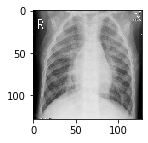

Predicted Label 1
True Label [1]


In [123]:
plt.figure(figsize=(2,2))
plt.imshow(X_test[401],cmap="gray")
plt.show()
results = predictor.predict(X_test[401].reshape(1,128,128,3))
class_id = int(np.squeeze(results['predictions']) > 0.5)
print('Predicted Label', class_id )
print('True Label', (y_test[401]))



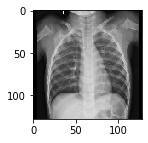

Predicted Label 0
True Label [0]


In [124]:
plt.figure(figsize=(2,2))
plt.imshow(X_test[3],cmap="gray")
plt.show()
results = predictor.predict(X_test[3].reshape(1,128,128,3))
class_id = int(np.squeeze(results['predictions']) > 0.5)
print('Predicted Label', class_id )
print('True Label', (y_test[3]))



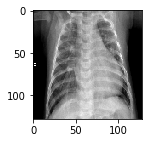

Predicted Label 1
True Label [1]


In [126]:
plt.figure(figsize=(2,2))
plt.imshow(X_test[600],cmap="gray")
plt.show()
results = predictor.predict(X_test[600].reshape(1,128,128,3))
class_id = int(np.squeeze(results['predictions']) > 0.5)
print('Predicted Label', class_id )
print('True Label', (y_test[600]))



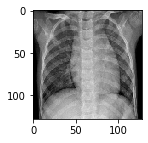

Predicted Label 0
True Label [0]


In [127]:
plt.figure(figsize=(2,2))
plt.imshow(X_test[150],cmap="gray")
plt.show()
results = predictor.predict(X_test[150].reshape(1,128,128,3))
class_id = int(np.squeeze(results['predictions']) > 0.5)
print('Predicted Label', class_id )
print('True Label', (y_test[150]))



## Delete Model Endpoint

In [129]:
sagemaker_session.delete_endpoint(predictor.endpoint)